In [1]:
#export
"""
This is for all short utilities that converts from 1 data type to another. They
might feel they have different styles, as :class:`toFloat` converts object iterator to
float iterator, while :class:`toPIL` converts single image url to single PIL image,
whereas :class:`toSum` converts float iterator into a single float value.

The general convention is, if the intended operation sounds simple (convert to floats,
strings, types, ...), then most likely it will convert iterator to iterator, as you
can always use the function directly if you only want to apply it on 1 object.

If it sounds complicated (convert to PIL image, tensor, ...) then most likely it will
convert object to object. Lastly, there are some that just feels right to input
an iterator and output a single object (like getting max, min, std, mean values)."""
__all__ = ["toTensor", "toRange", "toList",
           "toSum", "toProd", "toAvg", "toMean", "toMax", "toMin", "toPIL", "toImg",
           "toRgb", "toRgba", "toGray", "toDict",
           "toFloat", "toInt", "toBytes"]
import re, k1lib, math, os, numpy as np, io, base64
from k1lib.cli.init import BaseCli, Table, Row, T, yieldT; import k1lib.cli as cli
from k1lib.cli.typehint import *; import matplotlib as mpl; import matplotlib.pyplot as plt
from collections import deque; from typing import Iterator, Any, List, Set, Tuple, Dict, Callable, Union
settings = k1lib.settings.cli
try: import PIL; hasPIL = True
except: hasPIL = False
try: import torch; hasTorch = True
except: torch = k1lib.Object().withAutoDeclare(lambda: type("RandomClass", (object, ), {})); hasTorch = False
try: import rdkit; hasRdkit = True
except: hasRdkit = False

In [2]:
cli.init.patchNumpy()

In [3]:
#export
class toTensor(BaseCli):
    def __init__(self, dtype=torch.float32):
        """Converts generator to :class:`torch.Tensor`. Essentially
``torch.tensor(list(it))``.

Also checks if input is a PIL Image. If yes, turn it into a :class:`torch.Tensor`
and return."""
        self.dtype = dtype
    def __ror__(self, it:Iterator[float]) -> torch.Tensor:
        try:
            import PIL; pic=it
            if isinstance(pic, PIL.Image.Image): # stolen from torchvision ToTensor transform
                mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
                img = torch.from_numpy(np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True))
                if pic.mode == '1': img = 255 * img
                img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
                return img.permute((2, 0, 1)).contiguous().to(self.dtype) # put it from HWC to CHW format
        except: pass
        if isinstance(it, np.ndarray): return torch.tensor(it).to(self.dtype)
        return torch.tensor(list(it)).to(self.dtype)

In [4]:
assert (range(3) | toTensor(torch.float64)).dtype == torch.float64

In [5]:
#export
class toList(BaseCli): # this still exists cause some LLVM optimizations are done on this, and too tired to change that at the moment
    def __init__(self):
        """Converts generator to list. :class:`list` would do the
same, but this is just to maintain the style"""
        super().__init__()

    def _typehint(self, inp):
        if isinstance(inp, tListIterSet): return tList(inp.child)
        if isinstance(inp, tCollection): return inp
        return tList(tAny())
    def __ror__(self, it:Iterator[Any]) -> List[Any]: return list(it)
def _toRange(it):
    for i, _ in enumerate(it): yield i
class toRange(BaseCli):
    def __init__(self):
        """Returns iter(range(len(it))), effectively"""
        super().__init__()
    def __ror__(self, it:Iterator[Any]) -> Iterator[int]:
        try: return range(len(it))
        except: return _toRange(it)
tOpt.addPass(lambda cs, ts, _: [cs[0]], [toRange, toRange])

In [6]:
assert [2, 3.5, "ah", torch.randn(2, 3)] | tCheck() | cli.apply(type) | cli.deref() == [int, float, str, torch.Tensor]
assert range(10, 20) | tCheck() | toRange() == range(0, 10)

In [7]:
#export
settings.add("arrayTypes", (torch.Tensor, np.ndarray), "default array types used to accelerate clis")
def genericTypeHint(inp):
    if isinstance(inp, tListIterSet): return inp.child
    if isinstance(inp, tCollection): return inp.children[0]
    if isinstance(inp, tArrayTypes): return inp.child
    return tAny()
class toSum(BaseCli):
    def __init__(self):
        """Calculates the sum of list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    # returns 45
    range(10) | toSum()"""
        super().__init__()
    def _typehint(self, inp): return genericTypeHint(inp)
    def __ror__(self, it:Iterator[float]):
        if isinstance(it, settings.arrayTypes): return it.sum()
        return sum(it)
class toProd(BaseCli):
    def __init__(self):
        """Calculates the product of a list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    # returns 362880
    range(1,10) | toProd()"""
        super().__init__()
    def _typehint(self, inp): return genericTypeHint(inp)
    def __ror__(self, it):
        if isinstance(it, settings.arrayTypes): return it.prod()
        else: return math.prod(it)
class toAvg(BaseCli):
    def __init__(self):
        """Calculates average of list of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    # returns 4.5
    range(10) | toAvg()
    # returns nan
    [] | toAvg()"""
        super().__init__()
    def _typehint(self, inp):
        i = None
        if isinstance(inp, tListIterSet): i = inp.child
        if isinstance(inp, tCollection): i = inp.children[0]
        if isinstance(inp, tArrayTypes): i = inp.child
        if i is not None: return float if i == int else i
        return tAny()
    def __ror__(self, it:Iterator[float]):
        if isinstance(it, settings.arrayTypes): return it.mean()
        s = 0; i = -1
        for i, v in enumerate(it): s += v
        i += 1
        if not k1lib.settings.cli.strict and i == 0: return float("nan")
        return s / i
toMean = toAvg

In [8]:
assert range(10) | tCheck() | toSum() == 45
assert range(1,10) | tCheck() | toProd() == 362880
assert range(10) | tCheck() | toAvg() == 4.5
assert id([] | toAvg()) == id(float("nan"))
assert np.linspace(2, 3) | toAvg() == 2.5

In [9]:
#export
class toMax(BaseCli):
    def __init__(self):
        """Calculates the max of a bunch of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    # returns 6
    [2, 5, 6, 1, 2] | toMax()"""
        super().__init__()
    def __ror__(self, it:Iterator[float]) -> float:
        if isinstance(it, settings.arrayTypes): return it.max()
        return max(it)
class toMin(BaseCli):
    def __init__(self):
        """Calculates the min of a bunch of numbers. Can pipe in :class:`torch.Tensor` or :class:`numpy.ndarray`.
Example::

    # returns 1
    [2, 5, 6, 1, 2] | toMin()"""
        super().__init__()
    def __ror__(self, it:Iterator[float]) -> float:
        if isinstance(it, settings.arrayTypes): return it.min()
        return min(it)

In [10]:
assert [2, 5, 6, 1, 2] | toMax() == 6
assert [2, 5, 6, 1, 2] | toMin() == 1

In [11]:
#export
settings.add("font", None, "default font file. Best to use .ttf files, used by toPIL()")
settings.add("chem", k1lib.Settings().add("imgSize", 200, "default image size used in toPIL() when drawing rdkit molecules"), "chemistry-related settings")
def cropToContentNp(ogIm, pad=10):
    dim = len(ogIm.shape); im = ogIm
    if dim > 2: im = im.mean(0)
    coords = np.argwhere(im.max()-im); x_min, y_min = coords.min(axis=0); x_max, y_max = coords.max(axis=0)
    return ogIm[x_min-pad:x_max+1+pad, y_min-pad:y_max+1+pad] if dim == 2 else ogIm[:,x_min-pad:x_max+1+pad, y_min-pad:y_max+1+pad]
def cropToContentPIL(im, pad=0):
    im = im | toTensor(int) | cli.op().numpy() | cli.aS(cropToContentNp, pad)
    return torch.from_numpy(im).permute(1, 2, 0) | toImg() if len(im.shape) > 2 else im | toImg()
class toPIL(BaseCli):
    def __init__(self):
        """Converts multiple data types into a PIL image.
Example::

    # grabs first image in the current folder
    ls(".") | toPIL().all() | item()
    # converts from tensor/array to image
    torch.randn(100, 200) | toPIL()
    # grabs image, converts to byte stream, and converts back to image
    "abc.jpg" | toPIL() | toBytes() | toPIL()
    # converts paragraphs to image
    ["abc", "def"] | toPIL()
    # converts SMILES string to molecule, then to image
    "c1ccc(C)cc1" | toMol() | toImg()

You can also save a matplotlib figure by piping in a :class:`matplotlib.figure.Figure` object::

    x = np.linspace(0, 4)
    plt.plot(x, x**2)
    plt.gcf() | toPIL()

.. note::
    
    If you are working with image tensors, which is typically have
    dimensions of (C, H, W), you have to permute it to PIL's (H, W, C)
    first before passing it into this cli.
    
    Also it's expected that
    your tensor image ranges from 0-255, and not 0-1. Make sure you
    renormalize it"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp):
        return PIL.Image.Image
    def __ror__(self, path) -> "PIL.Image.Image":
        if isinstance(path, str):
            return self.PIL.Image.open(os.path.expanduser(path))
        if isinstance(path, bytes):
            return self.PIL.Image.open(io.BytesIO(path))
        if isinstance(path, torch.Tensor): path = path.numpy()
        if isinstance(path, np.ndarray):
            return self.PIL.Image.fromarray(path.astype("uint8"))
        if isinstance(path, mpl.figure.Figure):
            canvas = path.canvas; canvas.draw()
            return self.PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
        if hasRdkit and isinstance(path, rdkit.Chem.rdchem.Mol):
            sz = settings.chem.imgSize
            return self.__ror__(rdkit.Chem.Draw.MolsToGridImage([path], subImgSize=[sz, sz]).data) | cli.aS(cropToContentPIL)
        path = path | cli.deref()
        if len(path) > 0 and isinstance(path[0], str):
            from PIL import ImageDraw
            h = path | cli.shape(0); w = path | cli.shape(0).all() | cli.aS(max)
            image = self.PIL.Image.new("L", (w*20, h*40), 255)
            font = PIL.ImageFont.truetype(settings.font, 18) if settings.font else None
            ImageDraw.Draw(image).text((20, 20), path | cli.join("\n"), 0, font=font)
            return image | cli.toTensor(int) | cli.op().numpy()[0]/255 | cli.aS(cropToContentNp) | cli.op()*255 | toImg()
        return NotImplemented
toImg = toPIL

[<PIL.Image.Image image mode=L size=200x100>,
 <PIL.Image.Image image mode=RGB size=640x480>,
 <PIL.Image.Image image mode=L size=37x42>,
 <PIL.Image.Image image mode=RGB size=182x122>]

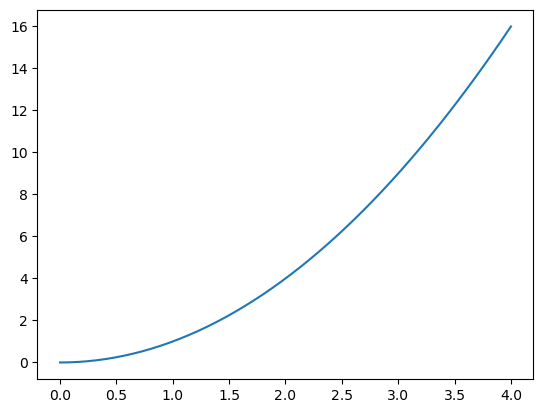

In [12]:
res = []
torch.randn(100, 200) | toImg() | cli.aS(res.append)
x = np.linspace(0, 4); plt.plot(x, x**2); plt.gcf() | toPIL() | cli.aS(res.append)
["abc", "def"] | toImg() | cli.aS(res.append)
"c1ccc(C)cc1" | cli.toMol() | toImg() | cli.aS(res.append); res

In [13]:
#export
class toRgb(BaseCli):
    def __init__(self):
        """Converts greyscale/rgb PIL image to rgb image.
Example::

    # reads image file and converts it to rgb
    "a.png" | toPIL() | toRgb()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        rgbI = self.PIL.Image.new("RGB", i.size)
        rgbI.paste(i); return rgbI
class toRgba(BaseCli):
    def __init__(self):
        """Converts random PIL image to rgba image.
Example::

    # reads image file and converts it to rgba
    "a.png" | toPIL() | toRgba()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        rgbI = self.PIL.Image.new("RGBA", i.size)
        rgbI.paste(i); return rgbI
class toGray(BaseCli):
    def __init__(self):
        """Converts random PIL image to a grayscale image.
Example::

    # reads image file and converts it to rgba
    "a.png" | toPIL() | toGray()"""
        import PIL; self.PIL = PIL
    def _typehint(self, inp): return inp
    def __ror__(self, i):
        return self.PIL.ImageOps.grayscale(i)

In [14]:
#export
class toDict(BaseCli):
    def __init__(self, rows=False):
        """Converts 2 Iterators, 1 key, 1 value into a dictionary.
Example::

    # returns {1: 3, 2: 4}
    [[1, 2], [3, 4]] | toDict()
    # returns {1: 3, 2: 4}
    [[1, 3], [2, 4]] | toDict(True)

:params rows: if True, reads input in row by row, else reads
    in list of columns"""
        self.rows = rows
    def __ror__(self, it:Tuple[Iterator[T], Iterator[T]]) -> dict:
        if self.rows: return {_k:_v for _k, _v in it}
        else: return {_k:_v for _k, _v in zip(*it)}

In [15]:
assert [[1, 2], [3, 4]] | toDict() == {1: 3, 2: 4}
assert [[1, 3], [2, 4]] | toDict(True) == {1: 3, 2: 4}

In [16]:
#export
def _toop(toOp, c, force, defaultValue):
    return cli.apply(toOp, c) | (cli.apply(lambda x: x or defaultValue, c) if force else cli.filt(cli.op() != None, c))
def _toFloat(e) -> Union[float, None]:
    try: return float(e)
    except: return None
class toFloat(BaseCli):
    def __init__(self, *columns, mode=2):
        """Converts every row into a float. Example::

    # returns [1, 3, -2.3]
    ["1", "3", "-2.3"] | toFloat() | deref()
    # returns [[1.0, 'a'], [2.3, 'b'], [8.0, 'c']]
    [["1", "a"], ["2.3", "b"], [8, "c"]] | toFloat(0) | deref()

With weird rows::

    # returns [[1.0, 'a'], [8.0, 'c']]
    [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0) | deref()
    # returns [[1.0, 'a'], [0.0, 'b'], [8.0, 'c']]
    [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0, force=True) | deref()

This also works well with :class:`torch.Tensor` and :class:`numpy.ndarray`,
as they will not be broken up into an iterator::

    # returns a numpy array, instead of an iterator
    np.array(range(10)) | toFloat()

:param columns: if nothing, then will convert each row. If available, then
    convert all the specified columns
:param mode: different conversion styles
    - 0: simple ``float()`` function, fastest, but will throw errors if it can't be parsed
    - 1: if there are errors, then replace it with zero
    - 2: if there are errors, then eliminate the row"""
        self.columns = columns; self.mode = mode;
    def __ror__(self, it):
        columns = self.columns; mode = self.mode
        if len(columns) == 0:
            if isinstance(it, np.ndarray): return it.astype(float)
            if isinstance(it, torch.Tensor): return it.float()
            if mode == 0: return it | cli.apply(float)
            return it | _toop(_toFloat, None, mode == 1, 0.0)
        else: return it | cli.init.serial(*(_toop(_toFloat, c, mode == 1, 0.0) for c in columns))

In [17]:
#export
def _toInt(e) -> Union[int, None]:
    try: return int(float(e))
    except: return None
class toInt(BaseCli):
    def __init__(self, *columns, mode=2):
        """Converts every row into an integer. Example::

    # returns [1, 3, -2]
    ["1", "3", "-2.3"] | toInt() | deref()

:param columns: if nothing, then will convert each row. If available, then
    convert all the specified columns
:param mode: different conversion styles
    - 0: simple ``float()`` function, fastest, but will throw errors if it can't be parsed
    - 1: if there are errors, then replace it with zero
    - 2: if there are errors, then eliminate the row

See also: :meth:`toFloat`"""
        self.columns = columns; self.mode = mode;
    def __ror__(self, it):
        columns = self.columns; mode = self.mode
        if len(columns) == 0:
            if isinstance(it, np.ndarray): return it.astype(int)
            if isinstance(it, torch.Tensor): return it.int()
            if mode == 0: return it | cli.apply(int)
            return it | _toop(_toInt, None, mode == 1, 0.0)
        else: return it | cli.init.serial(*(_toop(_toInt, c, mode == 1, 0.0) for c in columns))

In [18]:
assert ["1", "3", "-2.3"] | toFloat() | cli.deref() == [1, 3, -2.3]
assert [["1", "a"], ["2.3", "b"], [8, "c"]] | toFloat(0) | cli.deref() == [[1.0, 'a'], [2.3, 'b'], [8.0, 'c']]
assert ["1", "3", "-2.3"] | toInt() | cli.deref() == [1, 3, -2]
assert [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0, mode=1) | cli.deref() == [[1.0, 'a'], [0.0, 'b'], [8.0, 'c']]
assert [["1", "a"], ["c", "b"], [8, "c"]] | toFloat(0) | cli.deref() == [[1.0, 'a'], [8.0, 'c']]
assert isinstance(np.array(range(10)) | toFloat(), np.ndarray)

In [19]:
#export
class toBytes(BaseCli):
    def __init__(self):
        """Converts several object types to bytes.
Example::

    # converts string to bytes
    "abc" | toBytes()
    # converts image to base64 bytes
    torch.randn(200, 100) | toImg() | toBytes()"""
        pass
    def __ror__(self, it):
        if isinstance(it, str): return it.encode()
        if hasPIL:
            if isinstance(it, PIL.Image.Image):
                it = it | toRgb()
                buffered = io.BytesIO()
                it.save(buffered, format="JPEG")
                return buffered.getvalue()
        return NotImplemented

In [20]:
#export
try:
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import AllChem
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.drawOptions.addAtomIndices = True
    __all__ = [*__all__, "toMol", "toSmiles"]
    def toMol():
        """Smiles to molecule.
Example::

    "c1ccc(C)cc1" | toMol()"""
        return cli.aS(Chem.MolFromSmiles)
    def toSmiles():
        """Molecule to smiles.
Example::

    "c1ccc(C)cc1" | toMol() | toSmiles()"""
        return cli.aS(Chem.MolToSmiles)
except: pass

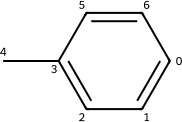

In [21]:
"c1ccc(C)cc1" | toMol() | toImg()

In [22]:
"c1ccc(C)cc1" | cli.aS(Chem.MolFromSmiles) | cli.aS(Chem.AllChem.EmbedMolecule) | cli.aS(print)

0


[02:26:48] Molecule does not have explicit Hs. Consider calling AddHs()


In [23]:
!../../export.py cli/conv

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/cli/../../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.2
Uninstalling k1lib-1.2:
  Successfully uninstalled k1lib-1.2
running install
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/torch/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt